In [105]:

#conda install -c conda-forge matplotlib metpy cartopy cython boto boto3 netcdf4
#pip install nexradaws

In [106]:
#https://www.lrc.usace.army.mil/Portals/36/docs/projects/April%202013%20Flood%20Report/April%202013%20Post%20Flood%20Survey%20Report_FINAL_APRIL2017.pdf


In [1]:
import nexradaws
import time
import tempfile
import os
import shutil
import pyart
from datetime import datetime, timedelta
from matplotlib import pyplot as plt

import cartopy.crs as ccrs
import cartopy.feature as cfeature

from cartopy.feature import NaturalEarthFeature
import matplotlib.colors as colors


import numpy as np

import pytz
import cartopy.io.shapereader as shpreader
from cartopy.feature import ShapelyFeature
from copy import deepcopy

from matplotlib_scalebar.scalebar import ScaleBar
#from cartopy.mpl.scalebar import fancy_scalebar

import numpy as np
from math import atan2 as atan2
import warnings
#import geopandas

%matplotlib inline

#This code courtesy and gratefully received from Tim Lang @tjlang on twitter

def gc_latlon_bear_dist(lat1, lon1, bear, dist):
    """
    Input lat1/lon1 as decimal degrees, as well as bearing and distance from
    the coordinate. Returns lat2/lon2 of final destination. Cannot be
    vectorized due to atan2.
    """
    re = 6371.1  # km
    lat1r = np.deg2rad(lat1)
    lon1r = np.deg2rad(lon1)
    bearr = np.deg2rad(bear)
    lat2r = np.arcsin((np.sin(lat1r) * np.cos(dist/re)) +
                      (np.cos(lat1r) * np.sin(dist/re) * np.cos(bearr)))
    lon2r = lon1r + atan2(np.sin(bearr) * np.sin(dist/re) *
                          np.cos(lat1r), np.cos(dist/re) - np.sin(lat1r) *
                          np.sin(lat2r))
    return np.rad2deg(lat2r), np.rad2deg(lon2r)
 
 
 
def add_scale_line(scale, ax, projection, color='k',
                  linewidth=None, fontsize=None, fontweight=None):
    """
    Adds a line that shows the map scale in km. The line will automatically
    scale based on zoom level of the map. Works with cartopy.
 
    Parameters
    ----------
    scale : scalar
        Length of line to draw, in km.
    ax : matplotlib.pyplot.Axes instance
        Axes instance to draw line on. It is assumed that this was created
        with a map projection.
    projection : cartopy.crs projection
        Cartopy projection being used in the plot.
 
    Other Parameters
    ----------------
    color : str
        Color of line and text to draw. Default is black.
    """
    frac_lat = 0.1  # distance fraction from bottom of plot
    frac_lon = 0.5  # distance fraction from left of plot
    e1 = ax.get_extent()
    center_lon = e1[0] + frac_lon * (e1[1] - e1[0])
    center_lat = e1[2] + frac_lat * (e1[3] - e1[2])
    # Main line
    lat1, lon1 = gc_latlon_bear_dist(
        center_lat, center_lon, -90, scale / 2.0)  # left point
    lat2, lon2 = gc_latlon_bear_dist(
        center_lat, center_lon, 90, scale / 2.0)  # right point
    if lon1 <= e1[0] or lon2 >= e1[1]:
        warnings.warn('Scale line longer than extent of plot! ' +
                      'Try shortening for best effect.')
    ax.plot([lon1, lon2], [lat1, lat2], linestyle='-',
            color=color, transform=projection, 
            linewidth=linewidth)
    # Draw a vertical hash on the left edge
    lat1a, lon1a = gc_latlon_bear_dist(
        lat1, lon1, 180, frac_lon * scale / 20.0)  # bottom left hash
    lat1b, lon1b = gc_latlon_bear_dist(
        lat1, lon1, 0, frac_lon * scale / 20.0)  # top left hash
    ax.plot([lon1a, lon1b], [lat1a, lat1b], linestyle='-',
            color=color, transform=projection, linewidth=linewidth)
    # Draw a vertical hash on the right edge
    lat2a, lon2a = gc_latlon_bear_dist(
        lat2, lon2, 180, frac_lon * scale / 20.0)  # bottom right hash
    lat2b, lon2b = gc_latlon_bear_dist(
        lat2, lon2, 0, frac_lon * scale / 20.0)  # top right hash
    ax.plot([lon2a, lon2b], [lat2a, lat2b], linestyle='-',
            color=color, transform=projection, linewidth=linewidth)
    # Draw scale label
    ax.text(center_lon, center_lat - frac_lat * (e1[3] - e1[2]) / 4.0,
            str(int(scale)) + ' km', horizontalalignment='center',
            verticalalignment='center', color=color, fontweight=fontweight,
            fontsize=fontsize)
 


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [38]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}


<IPython.core.display.Javascript object>

In [39]:
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}

/Users/scollis/miniconda3/envs/chihydro/lib/python3.8/site-packages/matplotlib_inline/config.py:61: DeprecationWarning: InlineBackend._print_figure_kwargs_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _update_figure_formatters(self):


In [3]:
#https://stackoverflow.com/questions/32237862/find-the-closest-date-to-a-given-date/32237949
def nearest(items, pivot):
    return min(items, key=lambda x: abs(x - pivot))


# This is a VERY LAZY function. 
#No testing and if it gets a file Py-ART can not read it will fail, ungracefully

def get_my_radar(connex, site, this_datetime):
    tlocation = tempfile.mkdtemp()
    these_scans = connex.get_avail_scans(this_datetime.year,this_datetime.month, this_datetime.day, site)
    these_times = [scan.scan_time for scan in these_scans]
    targ = this_datetime
    
    #Need to clean
    these_good_scans = []
    these_good_times = []
    for i in range(len(these_scans)):
        if these_times[i] is not None:
            these_good_times.append(these_times[i])
            these_good_scans.append(these_scans[i])
    
    print(len(these_good_scans), len(these_good_times))

    this_nearest_time = nearest(these_good_times, targ)
    this_index = these_good_times.index(this_nearest_time)
    lcn = templocation
    localfiles = conn.download(these_good_scans[this_index],lcn)
    return pyart.io.read(localfiles.success[0].filepath)

In [4]:
templocation = tempfile.mkdtemp()
conn = nexradaws.NexradAwsInterface()

In [111]:
#Some times
#mid storm
recent_time_n = datetime(2013, 4, 18, 10, 25, 0)

In [5]:
recent_time_n = datetime.utcnow() 
recent_time = recent_time_n.replace(tzinfo=pytz.UTC)
recent_radar = 'KBOX'
radar = get_my_radar(conn, recent_radar, recent_time)

rain_z = radar.fields['reflectivity']['data'].copy()
z_lin = 10.0**(radar.fields['reflectivity']['data']/10.)
rain_z = (z_lin/300.0)**(1./1.4)  #Z=300 R1.4
radar.add_field_like('reflectivity', 'rain_z',  rain_z, replace_existing = True)
radar.fields['rain_z']['units'] = 'mm/h'
radar.fields['rain_z']['standard_name'] = 'rainfall_rate'
radar.fields['rain_z']['long_name'] = 'rainfall_rate_from_z'
radar.fields['rain_z']['valid_min'] = 0
radar.fields['rain_z']['valid_max'] = 500

#https://journals.ametsoc.org/view/journals/apme/51/6/jamc-d-11-0112.1.xml
#https://journals.ametsoc.org/view/journals/apme/57/1/jamc-d-17-0090.1.xml?webtoken=19c5ca46-1588-422e-890c-13025bf7fe25


snow_z = radar.fields['reflectivity']['data'].copy()
z_lin = 10.0**(radar.fields['reflectivity']['data']/10.)
rain_z = (z_lin/200.)**(1./2)  #a=200 b 2
radar.add_field_like('reflectivity', 'snow_z',  snow_z, replace_existing = True)
radar.fields['snow_z']['units'] = 'mm/h'
radar.fields['snow_z']['standard_name'] = 'snowfall_rate'
radar.fields['snow_z']['long_name'] = 'snowfall_rate_from_z'
radar.fields['snow_z']['valid_min'] = 0
radar.fields['snow_z']['valid_max'] = 500



177 177
Downloaded KBOX20220129_150537_V06
1 out of 1 files downloaded...0 errors


In [6]:
 radar.time

{'units': 'seconds since 2022-01-29T15:05:37Z',
 'standard_name': 'time',
 'long_name': 'time_in_seconds_since_volume_start',
 'calendar': 'gregorian',
 'comment': 'Coordinate variable for time. Time at the center of each ray, in fractional seconds since the global variable time_coverage_start',
 'data': array([  0.763,   0.8  ,   0.84 , ..., 343.006, 343.044, 343.081])}

In [7]:
 radar.time['units'][14:]

'2022-01-29T15:05:37Z'

In [8]:
ff = time.strptime(radar.time['units'][14:], '%Y-%m-%dT%H:%M:%SZ')
strform = time.strftime('%Y%m%d-%H%M%S',ff)
print(strform)
base_file = '/Users/scollis/ubrims/out_' + strform

20220129-150537


In [11]:
#Evanston lat lon 42.0225805,-87.6615686
centerlat = 42.0225805
centerlon = -87.6615686

#chicagoish 

centerlat = 42.0
centerlon = -70.5
window = 4
locbox = [centerlon - window, centerlon + window, centerlat - window, centerlat + window]

/Users/scollis/miniconda3/envs/chihydro/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


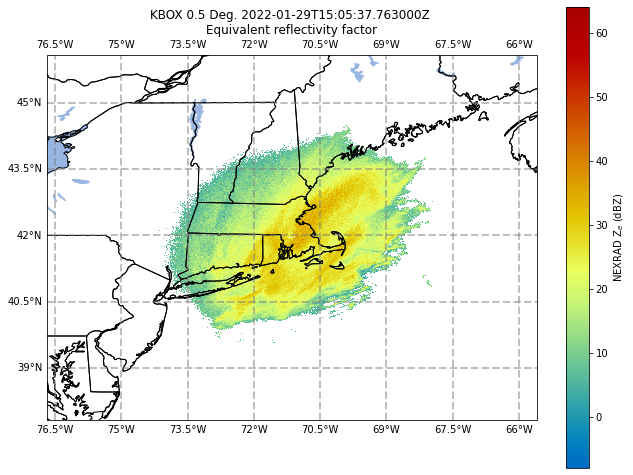

In [12]:
myf = plt.figure(figsize=[10,10])

map_panel_axes = [0.05, 0.05, .8, .8]
ax = myf.add_axes(map_panel_axes, projection=ccrs.PlateCarree())

myd = pyart.graph.RadarMapDisplay(radar)
myd.plot_ppi_map('reflectivity', 0, vmin=-8, vmax=64, ax=ax, embelish=False, colorbar_flag=False)

cbar = plt.colorbar(mappable=myd.plots[0], fraction=.1, shrink=.8, label='NEXRAD Z$_e$ (dBZ)')

gl = ax.gridlines(draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')

gl.ylabels_right = False
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES)
ax.add_feature(cfeature.LAKES, zorder=0)
plt.savefig(base_file+'_region.png')

/Users/scollis/miniconda3/envs/chihydro/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


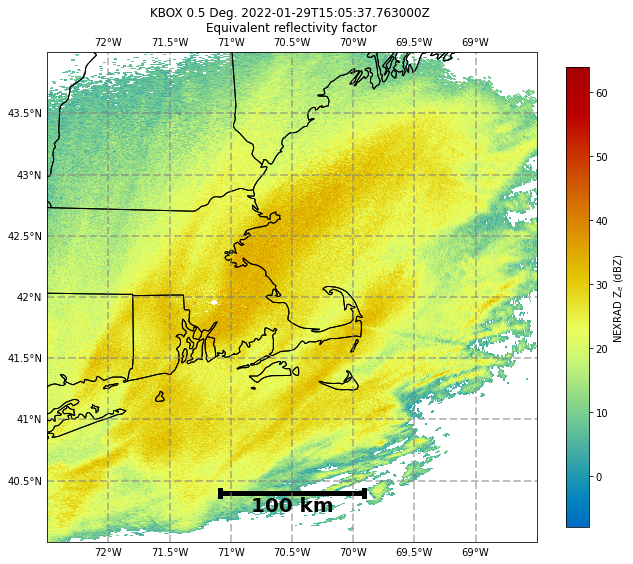

In [13]:
window = 2
locbox = [centerlon - window, centerlon + window, centerlat - window, centerlat + window]

myf = plt.figure(figsize=[10,10])

map_panel_axes = [0.05, 0.05, .8, .8]
ax = myf.add_axes(map_panel_axes, projection=ccrs.PlateCarree())

myd = pyart.graph.RadarMapDisplay(radar)
myd.plot_ppi_map('reflectivity', 0, vmin=-8, vmax=64, ax=ax, embelish=False, colorbar_flag=False)

cbar = plt.colorbar(mappable=myd.plots[0], fraction=.1, shrink=.8, label='NEXRAD Z$_e$ (dBZ)')

gl = ax.gridlines(draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')

gl.ylabels_right = False
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES)
ax.add_feature(cfeature.LAKES, zorder=0)
plt.xlim(locbox[0], locbox[1])
plt.ylim(locbox[2], locbox[3])
add_scale_line(100.0, ax, projection=ccrs.PlateCarree(), 
               color='black', linewidth=5,
              fontsize=20,
              fontweight='bold')


In [119]:
reader = shpreader.Reader("./city_detailed_utm/city_detailed_utm.shp")

myproj = ccrs.TransverseMercator(central_longitude=-87, 
                                 scale_factor=0.9996, 
                                 false_easting=500000)

shape_feature = ShapelyFeature(reader.geometries(),
                                crs=myproj,
                               edgecolor='black',
                              facecolor='none')

/var/folders/f4/f3jp1t2x0hddhf4vz50gzlnc0000gn/T/ipykernel_43528/1985935452.py:3: UserWarning: The default value for the *approx* keyword argument to TransverseMercator will change from True to False after 0.18.
  myproj = ccrs.TransverseMercator(central_longitude=-87,


In [120]:
#ccrs.TransverseMercator?

PROJCS["NAD_1983_UTM_Zone_16N",GEOGCS["GCS_North_American_1983",DATUM["D_North_American_1983",SPHEROID["GRS_1980",6378137,298.257222101]],PRIMEM["Greenwich",0],UNIT["Degree",0.017453292519943295]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-87],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["Meter",1]]



/Users/scollis/miniconda3/envs/chihydro/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


(40.5, 43.5)

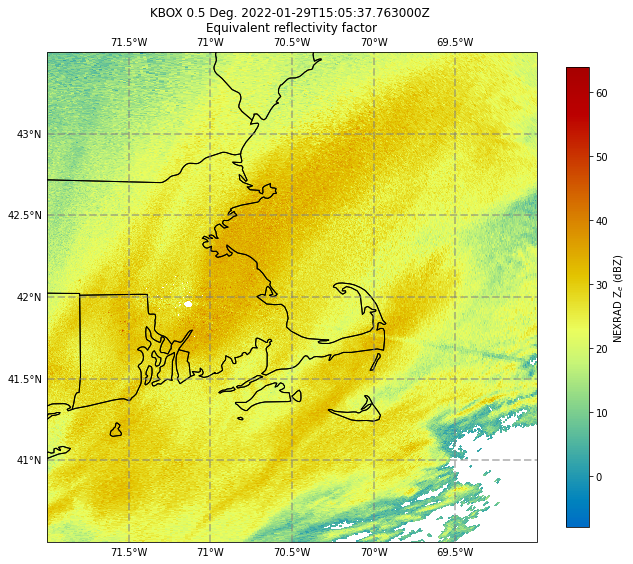

In [15]:
window = 1.5
locbox = [centerlon - window, centerlon + window, centerlat - window, centerlat + window]

myf = plt.figure(figsize=[10,10])

map_panel_axes = [0.05, 0.05, .8, .8]
ax = myf.add_axes(map_panel_axes, projection=ccrs.PlateCarree())

myd = pyart.graph.RadarMapDisplay(radar)
myd.plot_ppi_map('reflectivity', 0, vmin=-8, vmax=64, ax=ax, embelish=False, colorbar_flag=False)

cbar = plt.colorbar(mappable=myd.plots[0], fraction=.1, shrink=.8, label='NEXRAD Z$_e$ (dBZ)')
gl = ax.gridlines(draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')

gl.ylabels_right = False
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES)
ax.add_feature(cfeature.LAKES, zorder=0)
plt.xlim(locbox[0], locbox[1])
plt.ylim(locbox[2], locbox[3])


In [16]:
norm = colors.LogNorm(vmin=0.1, vmax=150)
norm = None

/Users/scollis/miniconda3/envs/chihydro/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


(40.5, 43.5)

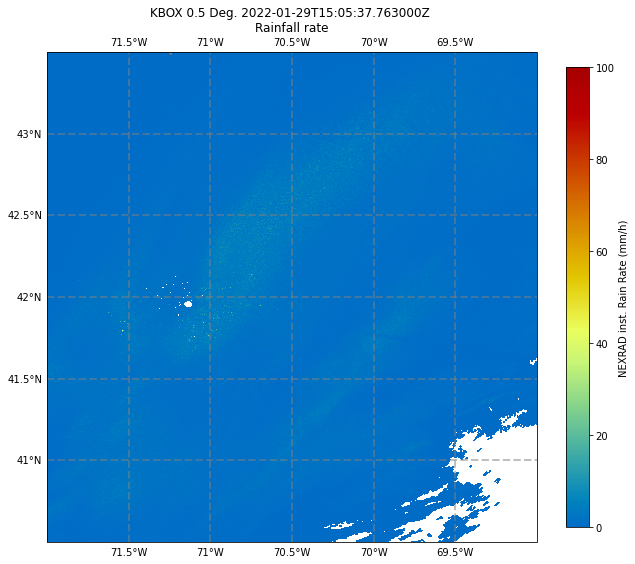

In [18]:
window = 1.5
locbox = [centerlon - window, centerlon + window, centerlat - window, centerlat + window]

myf = plt.figure(figsize=[10,10])

map_panel_axes = [0.05, 0.05, .8, .8]
ax = myf.add_axes(map_panel_axes, projection=ccrs.PlateCarree())

myd = pyart.graph.RadarMapDisplay(radar)
myd.plot_ppi_map('rain_z', 0, vmin=-.01, vmax=100., ax=ax, embelish=False, colorbar_flag=False,
                cmap=pyart.graph.cm_colorblind.HomeyerRainbow,
                norm=norm)

cbar = plt.colorbar(mappable=myd.plots[0], fraction=.1, shrink=.8, label='NEXRAD inst. Rain Rate (mm/h)')
gl = ax.gridlines(draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')

gl.ylabels_right = False

coast = NaturalEarthFeature(category='physical', scale='10m',
                            edgecolor='black', name='coastline')

lake = NaturalEarthFeature(category='physical', scale='10m',
                            edgecolor='gray', name='lakes',
                          facecolor='none', linewidth=2)


ax.add_feature(lake)
#ax.add_feature(cfeature.STATES)
#ax.add_feature(cfeature.LAKES, facecolor='none', edgecolor='black')
plt.xlim(locbox[0], locbox[1])
plt.ylim(locbox[2], locbox[3])


/Users/scollis/miniconda3/envs/chihydro/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


(41.0, 43.0)

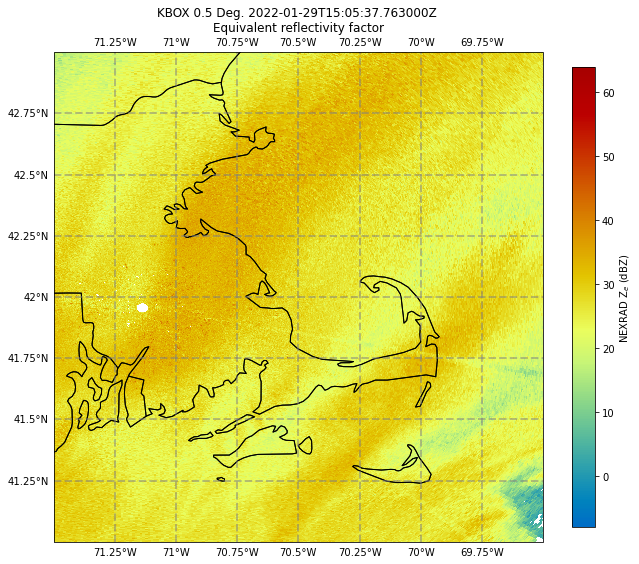

In [19]:
window = 1
locbox = [centerlon - window, centerlon + window, centerlat - window, centerlat + window]

myf = plt.figure(figsize=[10,10])

map_panel_axes = [0.05, 0.05, .8, .8]
ax = myf.add_axes(map_panel_axes, projection=ccrs.PlateCarree())

myd = pyart.graph.RadarMapDisplay(radar)
myd.plot_ppi_map('reflectivity', 0, vmin=-8, vmax=64, ax=ax, embelish=False, colorbar_flag=False)

cbar = plt.colorbar(mappable=myd.plots[0], fraction=.1, shrink=.8, label='NEXRAD Z$_e$ (dBZ)')
gl = ax.gridlines(draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')

gl.ylabels_right = False
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES)
ax.add_feature(cfeature.LAKES, zorder=0)
plt.xlim(locbox[0], locbox[1])
plt.ylim(locbox[2], locbox[3])


/Users/scollis/miniconda3/envs/chihydro/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


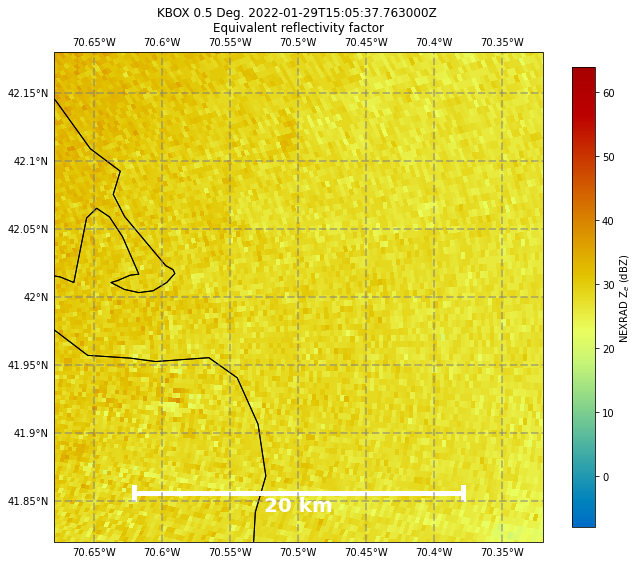

In [20]:
window = .18
locbox = [centerlon - window, centerlon + window, centerlat - window, centerlat + window]

myf = plt.figure(figsize=[10,10])

map_panel_axes = [0.05, 0.05, .8, .8]
ax = myf.add_axes(map_panel_axes, projection=ccrs.PlateCarree())

myd = pyart.graph.RadarMapDisplay(radar)
myd.plot_ppi_map('reflectivity', 0, vmin=-8, vmax=64, ax=ax, embelish=False, colorbar_flag=False)

cbar = plt.colorbar(mappable=myd.plots[0], fraction=.1, shrink=.8, label='NEXRAD Z$_e$ (dBZ)')
gl = ax.gridlines(draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')

gl.ylabels_right = False
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES)
ax.add_feature(cfeature.LAKES, zorder=0)


plt.xlim(locbox[0], locbox[1])
plt.ylim(locbox[2], locbox[3])


add_scale_line(20.0, ax, projection=ccrs.PlateCarree(), 
               color='w', linewidth=5,
              fontsize=20,
              fontweight='bold')


/Users/scollis/miniconda3/envs/chihydro/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


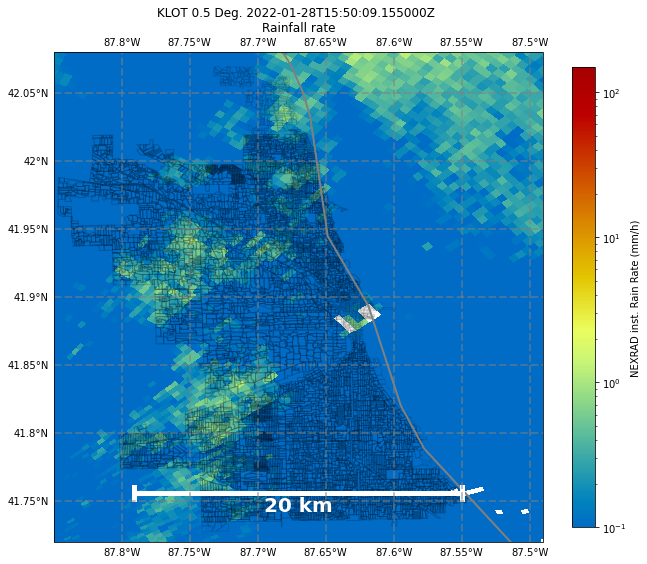

In [126]:
norm = colors.LogNorm(vmin=0.1, vmax=150)

window = 0.18
locbox = [centerlon - window, centerlon + window, centerlat - window, centerlat + window]

myf = plt.figure(figsize=[10,10])

map_panel_axes = [0.05, 0.05, .8, .8]
ax = myf.add_axes(map_panel_axes, projection=ccrs.PlateCarree())

myd = pyart.graph.RadarMapDisplay(radar)
myd.plot_ppi_map('rain_z', 0, vmin=-.01, vmax=100., ax=ax, embelish=False, colorbar_flag=False,
                cmap=pyart.graph.cm_colorblind.HomeyerRainbow,
                norm=norm)

cbar = plt.colorbar(mappable=myd.plots[0], fraction=.1, shrink=.8, label='NEXRAD inst. Rain Rate (mm/h)')
ax.add_feature(shape_feature,facecolor='none', alpha=.1)
gl = ax.gridlines(draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')

gl.ylabels_right = False

coast = NaturalEarthFeature(category='physical', scale='10m',
                            edgecolor='black', name='coastline')

lake = NaturalEarthFeature(category='physical', scale='10m',
                            edgecolor='gray', name='lakes',
                          facecolor='none', linewidth=2)


ax.add_feature(lake)
#ax.add_feature(cfeature.STATES)
#ax.add_feature(cfeature.LAKES, facecolor='none', edgecolor='black')
plt.xlim(locbox[0], locbox[1])
plt.ylim(locbox[2], locbox[3])

add_scale_line(20.0, ax, projection=ccrs.PlateCarree(), 
               color='w', linewidth=5,
              fontsize=20,
              fontweight='bold')


/Users/scollis/miniconda3/envs/chihydro/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


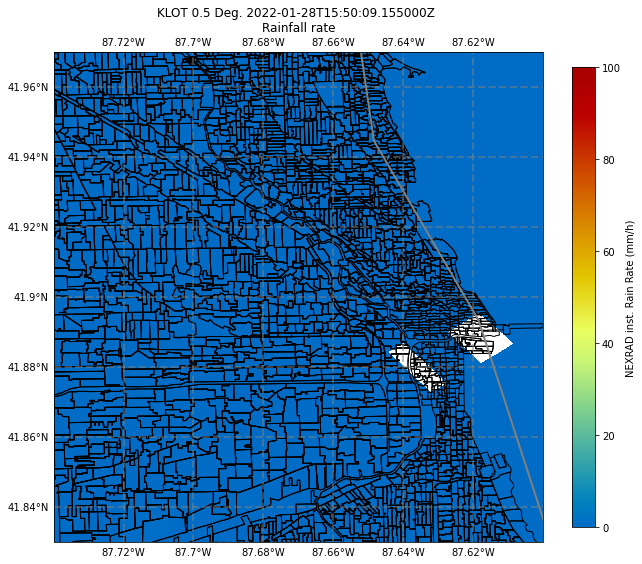

In [127]:
norm = None
window = 0.07
locbox = [centerlon - window, centerlon + window, centerlat - window, centerlat + window]

myf = plt.figure(figsize=[10,10])

map_panel_axes = [0.05, 0.05, .8, .8]
ax = myf.add_axes(map_panel_axes, projection=ccrs.PlateCarree())

myd = pyart.graph.RadarMapDisplay(radar)
myd.plot_ppi_map('rain_z', 0, vmin=-.01, vmax=100., ax=ax, embelish=False, colorbar_flag=False,
                cmap=pyart.graph.cm_colorblind.HomeyerRainbow,
                norm=norm)

cbar = plt.colorbar(mappable=myd.plots[0], fraction=.1, shrink=.8, label='NEXRAD inst. Rain Rate (mm/h)')
ax.add_feature(shape_feature,facecolor='none')
gl = ax.gridlines(draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')

gl.ylabels_right = False

coast = NaturalEarthFeature(category='physical', scale='10m',
                            edgecolor='black', name='coastline')

lake = NaturalEarthFeature(category='physical', scale='10m',
                            edgecolor='gray', name='lakes',
                          facecolor='none', linewidth=2)


ax.add_feature(lake)
#ax.add_feature(cfeature.STATES)
#ax.add_feature(cfeature.LAKES, facecolor='none', edgecolor='black')
plt.xlim(locbox[0], locbox[1])
plt.ylim(locbox[2], locbox[3])
plt.savefig(base_file+'zoom_rain.png')


/Users/scollis/miniconda3/envs/chihydro/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


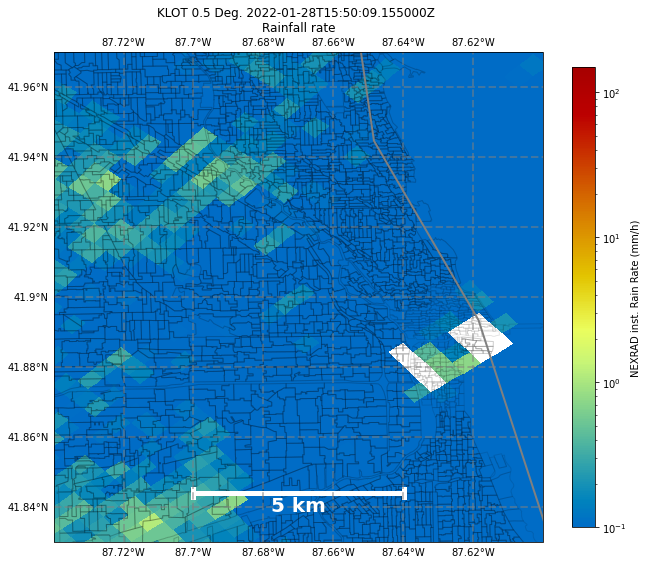

In [128]:
norm = colors.LogNorm(vmin=0.1, vmax=150)

window = 0.07
locbox = [centerlon - window, centerlon + window, centerlat - window, centerlat + window]

myf = plt.figure(figsize=[10,10])

map_panel_axes = [0.05, 0.05, .8, .8]
ax = myf.add_axes(map_panel_axes, projection=ccrs.PlateCarree())

myd = pyart.graph.RadarMapDisplay(radar)
myd.plot_ppi_map('rain_z', 0, vmin=-.01, vmax=100., ax=ax, embelish=False, colorbar_flag=False,
                cmap=pyart.graph.cm_colorblind.HomeyerRainbow,
                norm=norm)

cbar = plt.colorbar(mappable=myd.plots[0], fraction=.1, shrink=.8, label='NEXRAD inst. Rain Rate (mm/h)')
ax.add_feature(shape_feature,facecolor='none', alpha=.1)
gl = ax.gridlines(draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')

gl.ylabels_right = False

coast = NaturalEarthFeature(category='physical', scale='10m',
                            edgecolor='black', name='coastline')

lake = NaturalEarthFeature(category='physical', scale='10m',
                            edgecolor='gray', name='lakes',
                          facecolor='none', linewidth=2)


ax.add_feature(lake)
#ax.add_feature(cfeature.STATES)
#ax.add_feature(cfeature.LAKES, facecolor='none', edgecolor='black')
plt.xlim(locbox[0], locbox[1])
plt.ylim(locbox[2], locbox[3])

#great_circle_distance((X, Y), (X + 1, Y))
#scalebar = ScaleBar(100, "km", length_fraction=1./12.)
add_scale_line(5.0, ax, projection=ccrs.PlateCarree(), 
               color='w', linewidth=5,
              fontsize=20,
              fontweight='bold')
#ax.add_artist(scalebar)

plt.savefig(base_file+'zoom_rain_log.png')


In [129]:
ScaleBar?

In [130]:
locbox

[-87.74, -87.60000000000001, 41.83, 41.97]

/Users/scollis/miniconda3/envs/chihydro/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


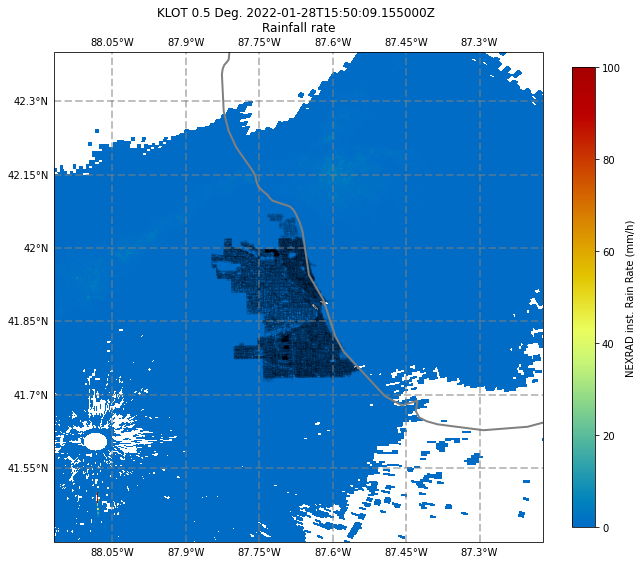

In [131]:
norm = None #colors.LogNorm(vmin=0.1, vmax=150)

window = 0.5
locbox = [centerlon - window, centerlon + window, centerlat - window, centerlat + window]

myf = plt.figure(figsize=[10,10])

map_panel_axes = [0.05, 0.05, .8, .8]
ax = myf.add_axes(map_panel_axes, projection=ccrs.PlateCarree())

myd = pyart.graph.RadarMapDisplay(radar)
myd.plot_ppi_map('rain_z', 0, vmin=-.01, vmax=100., ax=ax, embelish=False, colorbar_flag=False,
                cmap=pyart.graph.cm_colorblind.HomeyerRainbow,
                norm=norm)

cbar = plt.colorbar(mappable=myd.plots[0], fraction=.1, shrink=.8, label='NEXRAD inst. Rain Rate (mm/h)')
ax.add_feature(shape_feature,facecolor='none', alpha=.1)
gl = ax.gridlines(draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')

gl.ylabels_right = False

coast = NaturalEarthFeature(category='physical', scale='10m',
                            edgecolor='black', name='coastline')

lake = NaturalEarthFeature(category='physical', scale='10m',
                            edgecolor='gray', name='lakes',
                          facecolor='none', linewidth=2)


ax.add_feature(lake)
#ax.add_feature(cfeature.STATES)
#ax.add_feature(cfeature.LAKES, facecolor='none', edgecolor='black')
plt.xlim(locbox[0], locbox[1])
plt.ylim(locbox[2], locbox[3])
plt.savefig(base_file+'city_rain.png')


In [132]:
if False: 
    for i in [16,17,18,19,20,21,22,23]:
        for j in [0,10,20,30,40,50]:
            recent_time_n = datetime(2013, 4, 17, i, j, 0)
            recent_time = recent_time_n.replace(tzinfo=pytz.UTC)
            recent_radar = 'KLOT'
            radar = get_my_radar(conn, recent_radar, recent_time)
            ff = time.strptime(radar.time['units'][14:], '%Y-%m-%dT%H:%M:%SZ')
            strform = time.strftime('%Y%m%d-%H%M%S',ff)
            print(strform)
            base_file = '/Users/scollis/ubrims/out_' + strform
            rain_z = radar.fields['reflectivity']['data'].copy()
            z_lin = 10.0**(radar.fields['reflectivity']['data']/10.)
            rain_z = (z_lin/300.0)**(1./1.4)  #Z=300 R1.4
            radar.add_field_like('reflectivity', 'rain_z',  rain_z, replace_existing = True)
            radar.fields['rain_z']['units'] = 'mm/h'
            radar.fields['rain_z']['standard_name'] = 'rainfall_rate'
            radar.fields['rain_z']['long_name'] = 'rainfall_rate_from_z'
            radar.fields['rain_z']['valid_min'] = 0
            radar.fields['rain_z']['valid_max'] = 500

            window = 0.07
            locbox = [centerlon - window, centerlon + window, centerlat - window, centerlat + window]

            myf = plt.figure(figsize=[10,10])

            map_panel_axes = [0.05, 0.05, .8, .8]
            ax = myf.add_axes(map_panel_axes, projection=ccrs.PlateCarree())

            myd = pyart.graph.RadarMapDisplay(radar)
            myd.plot_ppi_map('rain_z', 0, vmin=-.01, vmax=100., ax=ax, embelish=False, colorbar_flag=False,
                            cmap=pyart.graph.cm_colorblind.HomeyerRainbow,
                            norm=norm)

            cbar = plt.colorbar(mappable=myd.plots[0], fraction=.1, shrink=.8, label='NEXRAD inst. Rain Rate (mm/h)')
            ax.add_feature(shape_feature,facecolor='none')
            gl = ax.gridlines(draw_labels=True,
                              linewidth=2, color='gray', alpha=0.5, linestyle='--')

            gl.ylabels_right = False

            coast = NaturalEarthFeature(category='physical', scale='10m',
                                        edgecolor='black', name='coastline')

            lake = NaturalEarthFeature(category='physical', scale='10m',
                                        edgecolor='gray', name='lakes',
                                      facecolor='none', linewidth=2)


            ax.add_feature(lake)
            #ax.add_feature(cfeature.STATES)
            #ax.add_feature(cfeature.LAKES, facecolor='none', edgecolor='black')
            plt.xlim(locbox[0], locbox[1])
            plt.ylim(locbox[2], locbox[3])
            plt.savefig(base_file+'zoom_rain.png')


In [133]:
#PROJCS["NAD_1983_StatePlane_Illinois_East_FIPS_1201_Feet",
#GEOGCS["GCS_North_American_1983",DATUM["D_North_American_1983",
#SPHEROID["GRS_1980",6378137.0,298.257222101]],PRIMEM["Greenwich",0.0],
#UNIT["Degree",0.0174532925199433]],PROJECTION["Transverse_Mercator"],
#PARAMETER["False_Easting",984250.0],PARAMETER["False_Northing",0.0],
#PARAMETER["Central_Meridian",-88.33333333333333],
#PARAMETER["Scale_Factor",0.999975],PARAMETER["Latitude_Of_Origin",36.66666666666666],
#UNIT["Foot_US",0.3048006096012192]]


In [134]:
reader = shpreader.Reader("./Neighborhoods_2012b.shp")

myproj = ccrs.TransverseMercator(central_longitude=-88.33333333333333, 
                                 scale_factor=0.999975, 
                                 false_easting=984250.0,
                                central_latitude=36.66666666666666)

shape_feature = ShapelyFeature(reader.geometries(),
                                crs=myproj,
                               edgecolor='black',
                              facecolor='none')

/var/folders/f4/f3jp1t2x0hddhf4vz50gzlnc0000gn/T/ipykernel_43528/2805842088.py:3: UserWarning: The default value for the *approx* keyword argument to TransverseMercator will change from True to False after 0.18.
  myproj = ccrs.TransverseMercator(central_longitude=-88.33333333333333,


In [135]:
reader = shpreader.Reader("./cityboundary.shp")

myproj = ccrs.TransverseMercator(central_longitude=-88.33333333333333, 
                                 scale_factor=0.999975, 
                                 false_easting=984250.0,
                                central_latitude=36.66666666666666)

shape_feature = ShapelyFeature(reader.geometries(),
                                crs=myproj,
                               edgecolor='black',
                              facecolor='none')

/var/folders/f4/f3jp1t2x0hddhf4vz50gzlnc0000gn/T/ipykernel_43528/2726858318.py:3: UserWarning: The default value for the *approx* keyword argument to TransverseMercator will change from True to False after 0.18.
  myproj = ccrs.TransverseMercator(central_longitude=-88.33333333333333,


/Users/scollis/miniconda3/envs/chihydro/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


Text(-1.8, 0.35, 'NEXRAD inst. Snow Rate (mm/h)')

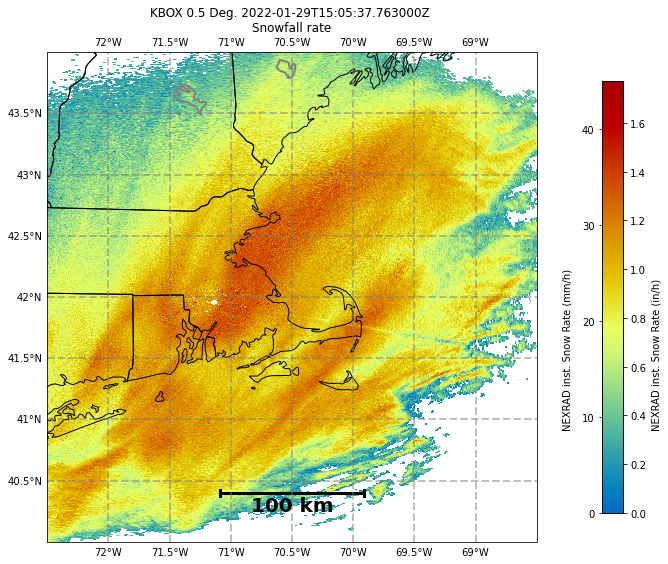

In [25]:
norm = None #colors.LogNorm(vmin=0.1, vmax=150)

smax = 45

window = 2
locbox = [centerlon - window, centerlon + window, centerlat - window, centerlat + window]

myf = plt.figure(figsize=[10,10])

map_panel_axes = [0.05, 0.05, .8, .8]
ax = myf.add_axes(map_panel_axes, projection=ccrs.PlateCarree())

myd = pyart.graph.RadarMapDisplay(radar)
myd.plot_ppi_map('snow_z', 0, vmin=-.01, vmax=smax, ax=ax, embelish=False, colorbar_flag=False,
                cmap=pyart.graph.cm_colorblind.HomeyerRainbow,
                norm=norm)

gl = ax.gridlines(draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')

gl.ylabels_right = False

coast = NaturalEarthFeature(category='physical', scale='10m',
                            edgecolor='black', name='coastline')

lake = NaturalEarthFeature(category='physical', scale='10m',
                            edgecolor='gray', name='lakes',
                          facecolor='none', linewidth=2)


ax.add_feature(lake)

ax.add_feature(cfeature.STATES, facecolor='none', edgecolor='black')
plt.xlim(locbox[0], locbox[1])
plt.ylim(locbox[2], locbox[3])

add_scale_line(100.0, ax, projection=ccrs.PlateCarree(), 
               color='black', linewidth=3,
              fontsize=20,
              fontweight='bold')

cbar = plt.colorbar(mappable=myd.plots[0], fraction=.1, shrink=.8)
pos = cbar.ax.get_position()
cbar.ax.set_aspect('auto')

cax2 = cbar.ax.twinx()
cax2.set_ylim([0,smax/25.4])
pos.x0 +=0.05
cbar.ax.set_position(pos)
cax2.set_position(pos)

cax2.text(2.3,0.35,'NEXRAD inst. Snow Rate (in/h)',rotation=90)
cax2.text(-1.8,0.35,'NEXRAD inst. Snow Rate (mm/h)',rotation=90)


#cbar.set_label('NEXRAD inst. Snow Rate (mm/h)', labelpad=1)


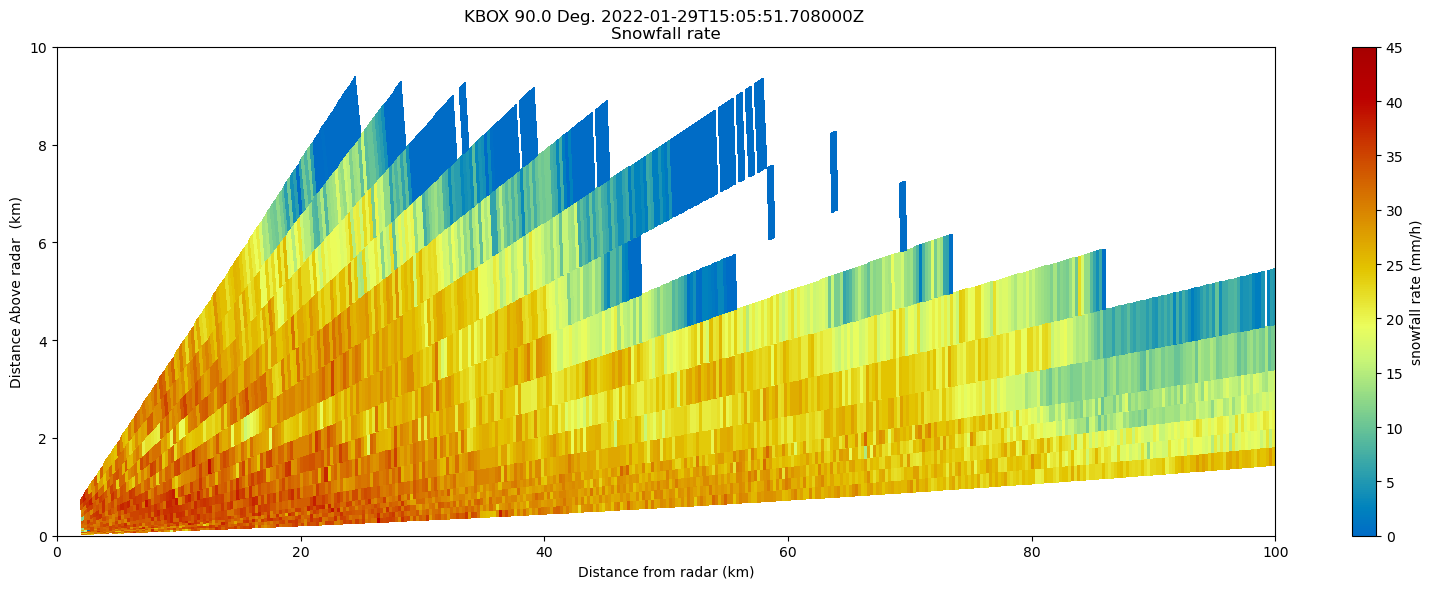

In [27]:
#figme=plt.figure(figsize=[15,5])
xsect = pyart.util.cross_section_ppi(radar, [90])
display = pyart.graph.RadarDisplay(xsect)
fig = plt.figure(figsize=(16, 6), dpi=100)
display.plot('snow_z', 0, vmin=0, vmax=45., cmap=pyart.graph.cm_colorblind.HomeyerRainbow)
display.set_limits((0, 100), (0, 10))
plt.tight_layout()

In [45]:
def do_my_plot(iradar):
    norm = None #colors.LogNorm(vmin=0.1, vmax=150)

    smax = 45
    
    centerlat = 42.0
    centerlon = -70.5
    window = 2
    locbox = [centerlon - window, centerlon + window, centerlat - window, centerlat + window]

    myf = plt.figure(figsize=[10,10])

    map_panel_axes = [0.05, 0.05, .8, .8]
    ax = myf.add_axes(map_panel_axes, projection=ccrs.PlateCarree())

    myd = pyart.graph.RadarMapDisplay(iradar)
    myd.plot_ppi_map('snow_z', 0, vmin=-.01, vmax=smax, ax=ax, embelish=False, colorbar_flag=False,
                    cmap=pyart.graph.cm_colorblind.HomeyerRainbow,
                    norm=norm)

    gl = ax.gridlines(draw_labels=True,
                      linewidth=2, color='gray', alpha=0.5, linestyle='--')

    gl.ylabels_right = False

    coast = NaturalEarthFeature(category='physical', scale='10m',
                                edgecolor='black', name='coastline')

    lake = NaturalEarthFeature(category='physical', scale='10m',
                                edgecolor='gray', name='lakes',
                              facecolor='none', linewidth=2)


    ax.add_feature(lake)

    ax.add_feature(cfeature.STATES, facecolor='none', edgecolor='black')
    plt.xlim(locbox[0], locbox[1])
    plt.ylim(locbox[2], locbox[3])

    add_scale_line(100.0, ax, projection=ccrs.PlateCarree(), 
                   color='black', linewidth=3,
                  fontsize=20,
                  fontweight='bold')

    cbar = plt.colorbar(mappable=myd.plots[0], fraction=.1, shrink=.8)
    pos = cbar.ax.get_position()
    cbar.ax.set_aspect('auto')

    cax2 = cbar.ax.twinx()
    cax2.set_ylim([0,smax/25.4])
    pos.x0 +=0.05
    cbar.ax.set_position(pos)
    cax2.set_position(pos)

    cax2.text(2.3,0.35,'NEXRAD inst. Snow Rate (in/h)',rotation=90)
    cax2.text(-1.8,0.35,'NEXRAD inst. Snow Rate (mm/h)',rotation=90)
    
    ff = time.strptime(iradar.time['units'][14:], '%Y-%m-%dT%H:%M:%SZ')
    strform = time.strftime('%Y%m%d-%H%M%S',ff)
    print(strform)
    base_file = '/Users/scollis/radarims/out_' + strform
    plt.savefig(base_file+'snow.png', facecolor='white', transparent=False)


    #cbar.set_label('NEXRAD inst. Snow Rate (mm/h)', labelpad=1)


184 184
Downloaded KBOX20220129_154045_V06
1 out of 1 files downloaded...0 errors


/Users/scollis/miniconda3/envs/chihydro/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


20220129-154045


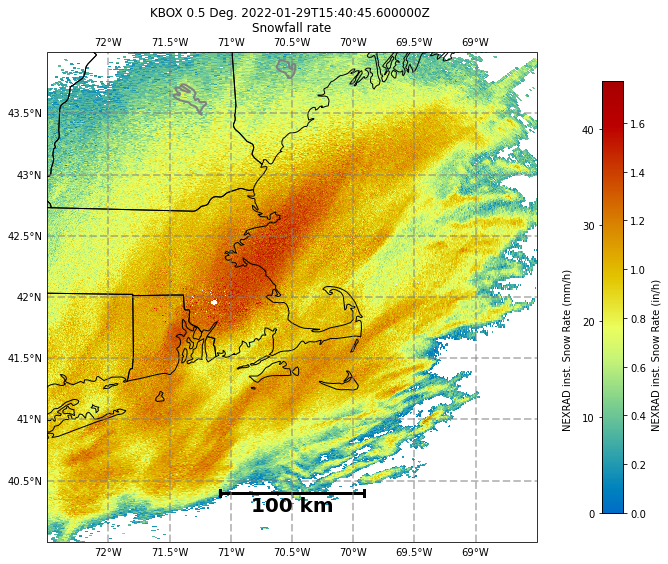

In [43]:
recent_time_n = datetime.utcnow() - timedelta(minutes=15)
recent_time = recent_time_n.replace(tzinfo=pytz.UTC)
recent_radar = 'KBOX'
radar = get_my_radar(conn, recent_radar, recent_time)

rain_z = radar.fields['reflectivity']['data'].copy()
z_lin = 10.0**(radar.fields['reflectivity']['data']/10.)
rain_z = (z_lin/300.0)**(1./1.4)  #Z=300 R1.4
radar.add_field_like('reflectivity', 'rain_z',  rain_z, replace_existing = True)
radar.fields['rain_z']['units'] = 'mm/h'
radar.fields['rain_z']['standard_name'] = 'rainfall_rate'
radar.fields['rain_z']['long_name'] = 'rainfall_rate_from_z'
radar.fields['rain_z']['valid_min'] = 0
radar.fields['rain_z']['valid_max'] = 500

#https://journals.ametsoc.org/view/journals/apme/51/6/jamc-d-11-0112.1.xml
#https://journals.ametsoc.org/view/journals/apme/57/1/jamc-d-17-0090.1.xml?webtoken=19c5ca46-1588-422e-890c-13025bf7fe25


snow_z = radar.fields['reflectivity']['data'].copy()
z_lin = 10.0**(radar.fields['reflectivity']['data']/10.)
rain_z = (z_lin/200.)**(1./2)  #a=200 b 2
radar.add_field_like('reflectivity', 'snow_z',  snow_z, replace_existing = True)
radar.fields['snow_z']['units'] = 'mm/h'
radar.fields['snow_z']['standard_name'] = 'snowfall_rate'
radar.fields['snow_z']['long_name'] = 'snowfall_rate_from_z'
radar.fields['snow_z']['valid_min'] = 0
radar.fields['snow_z']['valid_max'] = 500

do_my_plot(radar)

184 184
Downloaded KBOX20220129_154636_V06
1 out of 1 files downloaded...0 errors


/Users/scollis/miniconda3/envs/chihydro/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


20220129-154636


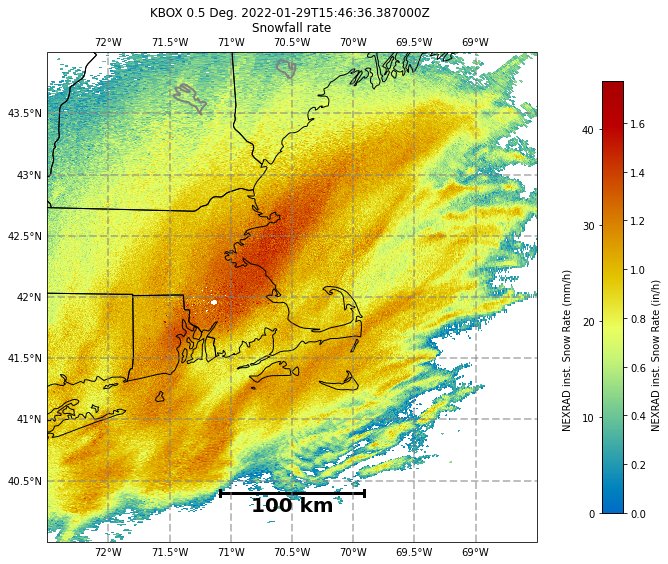

In [46]:
recent_time_n = datetime.utcnow()
recent_time = recent_time_n.replace(tzinfo=pytz.UTC)
recent_radar = 'KBOX'
radar = get_my_radar(conn, recent_radar, recent_time)

rain_z = radar.fields['reflectivity']['data'].copy()
z_lin = 10.0**(radar.fields['reflectivity']['data']/10.)
rain_z = (z_lin/300.0)**(1./1.4)  #Z=300 R1.4
radar.add_field_like('reflectivity', 'rain_z',  rain_z, replace_existing = True)
radar.fields['rain_z']['units'] = 'mm/h'
radar.fields['rain_z']['standard_name'] = 'rainfall_rate'
radar.fields['rain_z']['long_name'] = 'rainfall_rate_from_z'
radar.fields['rain_z']['valid_min'] = 0
radar.fields['rain_z']['valid_max'] = 500

#https://journals.ametsoc.org/view/journals/apme/51/6/jamc-d-11-0112.1.xml
#https://journals.ametsoc.org/view/journals/apme/57/1/jamc-d-17-0090.1.xml?webtoken=19c5ca46-1588-422e-890c-13025bf7fe25


snow_z = radar.fields['reflectivity']['data'].copy()
z_lin = 10.0**(radar.fields['reflectivity']['data']/10.)
rain_z = (z_lin/200.)**(1./2)  #a=200 b 2
radar.add_field_like('reflectivity', 'snow_z',  snow_z, replace_existing = True)
radar.fields['snow_z']['units'] = 'mm/h'
radar.fields['snow_z']['standard_name'] = 'snowfall_rate'
radar.fields['snow_z']['long_name'] = 'snowfall_rate_from_z'
radar.fields['snow_z']['valid_min'] = 0
radar.fields['snow_z']['valid_max'] = 500

do_my_plot(radar)

In [ ]:
for dd in [5,10,15,20,25,30,35,40,45,50,55, 60, 65, 70, 75]:
    recent_time_n = datetime.utcnow() - timedelta(minutes=dd)
    recent_time = recent_time_n.replace(tzinfo=pytz.UTC)
    recent_radar = 'KBOX'
    radar = get_my_radar(conn, recent_radar, recent_time)

    rain_z = radar.fields['reflectivity']['data'].copy()
    z_lin = 10.0**(radar.fields['reflectivity']['data']/10.)
    rain_z = (z_lin/300.0)**(1./1.4)  #Z=300 R1.4
    radar.add_field_like('reflectivity', 'rain_z',  rain_z, replace_existing = True)
    radar.fields['rain_z']['units'] = 'mm/h'
    radar.fields['rain_z']['standard_name'] = 'rainfall_rate'
    radar.fields['rain_z']['long_name'] = 'rainfall_rate_from_z'
    radar.fields['rain_z']['valid_min'] = 0
    radar.fields['rain_z']['valid_max'] = 500

    #https://journals.ametsoc.org/view/journals/apme/51/6/jamc-d-11-0112.1.xml
    #https://journals.ametsoc.org/view/journals/apme/57/1/jamc-d-17-0090.1.xml?webtoken=19c5ca46-1588-422e-890c-13025bf7fe25


    snow_z = radar.fields['reflectivity']['data'].copy()
    z_lin = 10.0**(radar.fields['reflectivity']['data']/10.)
    rain_z = (z_lin/200.)**(1./2)  #a=200 b 2
    radar.add_field_like('reflectivity', 'snow_z',  snow_z, replace_existing = True)
    radar.fields['snow_z']['units'] = 'mm/h'
    radar.fields['snow_z']['standard_name'] = 'snowfall_rate'
    radar.fields['snow_z']['long_name'] = 'snowfall_rate_from_z'
    radar.fields['snow_z']['valid_min'] = 0
    radar.fields['snow_z']['valid_max'] = 500

    do_my_plot(radar)

184 184
Downloaded KBOX20220129_154636_V06
1 out of 1 files downloaded...0 errors


/Users/scollis/miniconda3/envs/chihydro/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


20220129-154636
184 184
Downloaded KBOX20220129_154636_V06
1 out of 1 files downloaded...0 errors


/Users/scollis/miniconda3/envs/chihydro/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


20220129-154636
184 184
Downloaded KBOX20220129_154045_V06
1 out of 1 files downloaded...0 errors


/Users/scollis/miniconda3/envs/chihydro/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


20220129-154045
184 184
Downloaded KBOX20220129_154045_V06
1 out of 1 files downloaded...0 errors


/Users/scollis/miniconda3/envs/chihydro/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


20220129-154045
184 184
Downloaded KBOX20220129_153454_V06
1 out of 1 files downloaded...0 errors


/Users/scollis/miniconda3/envs/chihydro/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


20220129-153454
184 184
Downloaded KBOX20220129_152902_V06
1 out of 1 files downloaded...0 errors


/Users/scollis/miniconda3/envs/chihydro/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


20220129-152902
185 185
Downloaded KBOX20220129_152311_V06
1 out of 1 files downloaded...0 errors


/Users/scollis/miniconda3/envs/chihydro/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


20220129-152311
185 185
Downloaded KBOX20220129_151719_V06
1 out of 1 files downloaded...0 errors


/Users/scollis/miniconda3/envs/chihydro/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


20220129-151719
